In [1]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K

# from MD_AE_model import *
from model_no_bias import *
import mode_decomposition as md
import myplot

import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from contextlib import redirect_stdout

import time
import os
import configparser
import datetime
import wandb

# get system information
config = configparser.ConfigParser()
config.read('__system.ini')
system_info = config['system_info']

# use gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPU


2022-06-01 09:09:19.277147: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-01 09:09:19.860243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47208 MB memory:  -> device: 2, name: Quadro RTX 8000, pci bus id: 0000:a6:00.0, compute capability: 7.5


In [ ]:
%matplotlib notebook

In [2]:
# data
data_file = './data/PIV4_downsampled_by8.h5'
Ntrain = 1500 # snapshots for training
Nval = 632 # sanpshots for validation
Ntest = 600

# Boolean 
LATENT_STATE = True # save latent state
SHUFFLE = True # shuffle before splitting into sets, test set is extracted before shuffling
REMOVE_MEAN = True # train on fluctuating velocity

## ae configuration
lmb = 0.001 #1e-05 #regulariser
drop_rate = 0.0
features_layers = [32, 64, 128]
latent_dim = 2
act_fct = 'linear'
resize_meth = 'bilinear'
filter_window= (5,5)
batch_norm = True

## training
nb_epoch = 3000
batch_size = 100
learning_rate = 0.001

Nz = 24 # grid size
Ny = 21
Nu = 2
Nt = 2732 # number of snapshots available
D = 196.5 # mm diameter of bluff body
U_inf = 15 # m/s freestream velocity
f_piv = 720.0 # Hz PIV sampling frequency  
dt = 1.0/f_piv 
Nx = [Ny, Nz]

In [3]:
#============================= READ DATA FROM FILE ================================
hf = h5py.File('./data/training_data_1.h5','r')
u_all = np.array(hf.get('u_all'))
u_train = np.array(hf.get('u_train'))
u_val = np.array(hf.get('u_val'))
u_test = np.array(hf.get('u_test'))
u_mean_all = np.array(hf.get('u_mean_all'))
u_mean_train = np.array(hf.get('u_mean_train'))
u_mean_val = np.array(hf.get('u_mean_val'))
u_mean_test = np.array(hf.get('u_mean_test'))
hf.close()

## pre-training linear

In [4]:
mdl_linear = MD_Autoencoder(Nx,Nu,features_layers=features_layers,latent_dim=latent_dim,
        filter_window=filter_window,act_fct='linear',batch_norm=batch_norm,
        drop_rate=drop_rate, lmb=lmb)
mdl_linear.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
mdl_linear.evaluate(u_train[0,:,:,:,:],u_train[0,:,:,:,:],verbose=0)

2022-06-01 09:09:31.777690: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8400
2022-06-01 09:09:32.771347: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2.261545181274414

In [5]:
mdl_linear.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21, 24, 2)]  0           []                               
                                                                                                  
 encoder (Encoder)              (None, 2)            260800      ['input_1[0][0]']                
                                                                                                  
 z_0 (Lambda)                   (None, 1)            0           ['encoder[0][0]']                
                                                                                                  
 z_1 (Lambda)                   (None, 1)            0           ['encoder[0][0]']                
                                                                                              

In [6]:
hist_train = []
hist_val = []

In [8]:
pat = 100 # EarlyStopping
tempfn = './temp_pre-training-linear.h5'
model_cb=ModelCheckpoint(tempfn, monitor='val_loss',save_best_only=True,verbose=0,save_weights_only=True)
early_cb=EarlyStopping(monitor='val_loss', patience=pat,verbose=0)
cb = [model_cb, early_cb]

# mdl_linear.load_weights('./__experiments/pre-training-linear-1.h5')
# Training
hist0 = mdl_linear.fit(u_train[0,:,:,:,:], u_train[0,:,:,:,:],
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(u_val[0,:,:,:,:], u_val[0,:,:,:,:]),
                callbacks=cb,verbose=2)  
hist_train.extend(hist0.history['loss'])
hist_val.extend(hist0.history['val_loss'])

2022-05-31 14:28:55.142450: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8400
2022-05-31 14:28:56.286831: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/3000
15/15 - 3s - loss: 1.5133 - val_loss: 1.5428 - 3s/epoch - 203ms/step
Epoch 2/3000
15/15 - 1s - loss: 1.5127 - val_loss: 1.5379 - 532ms/epoch - 35ms/step
Epoch 3/3000
15/15 - 1s - loss: 1.5088 - val_loss: 1.5321 - 503ms/epoch - 34ms/step
Epoch 4/3000
15/15 - 0s - loss: 1.5072 - val_loss: 1.5326 - 440ms/epoch - 29ms/step
Epoch 5/3000
15/15 - 0s - loss: 1.5090 - val_loss: 1.5333 - 440ms/epoch - 29ms/step
Epoch 6/3000
15/15 - 0s - loss: 1.5085 - val_loss: 1.5368 - 460ms/epoch - 31ms/step
Epoch 7/3000
15/15 - 0s - loss: 1.5093 - val_loss: 1.5403 - 461ms/epoch - 31ms/step
Epoch 8/3000
15/15 - 0s - loss: 1.5077 - val_loss: 1.5366 - 451ms/epoch - 30ms/step
Epoch 9/3000
15/15 - 1s - loss: 1.5086 - val_loss: 1.5409 - 508ms/epoch - 34ms/step
Epoch 10/3000
15/15 - 0s - loss: 1.5101 - val_loss: 1.5425 - 464ms/epoch - 31ms/step
Epoch 11/3000
15/15 - 0s - loss: 1.5109 - val_loss: 1.5387 - 433ms/epoch - 29ms/step
Epoch 12/3000
15/15 - 0s - loss: 1.5087 - val_loss: 1.5389 - 433ms/epoch - 2

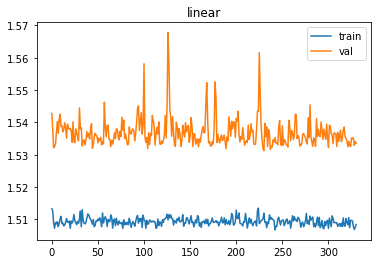

In [9]:
plt.figure()
plt.title('linear')
plt.plot(hist_train,label='train')
plt.plot(hist_val,label='val')
plt.legend()
plt.show()

In [6]:
mdl_linear.load_weights('./__experiments/pre-training-linear-1.h5')
print('best training loss:',mdl_linear.evaluate(u_train[0,:,:,:,:],u_train[0,:,:,:,:],verbose=0))

best training loss: 1.5012582540512085


In [57]:
# training or testing set
which = 'test'

latent_test = mdl_linear.encoder.predict(u_test[0,:,:,:,:])
latent_train = mdl_linear.encoder.predict(u_train[0,:,:,:,:])
linear_decoders = []

if which == 'train':
    z_l = latent_train
    u_in_l = u_train[0,:,:,:,:]
elif which == 'test':
    z_l = latent_test
    u_in_l = u_test[0,:,:,:,:]

for name in mdl_linear.name_decoder:
    linear_decoders.append(mdl_linear.get_layer(name))
linear_modes = []
for i in range(latent_dim):
    linear_modes.append(linear_decoders[i].predict(np.reshape(z_l[:,i],(-1,1))))
linear_modes = np.array(linear_modes)
y_test_sum = np.sum(linear_modes,axis=0)
    
y_test = mdl_linear.predict(u_in_l)

print('Are results calculated the two ways the same?',np.array_equal(y_test_sum,y_test))

loss_test_1 = mdl_linear.evaluate(u_in_l,u_in_l,verbose=0)
loss_test_2 = tf.keras.losses.MeanSquaredError()(u_in_l,y_test)
print('total loss:',loss_test_1,'    mse loss:',loss_test_2.numpy())

Are results calculated the two ways the same? True
total loss: 1.401880145072937     mse loss: 1.3987149


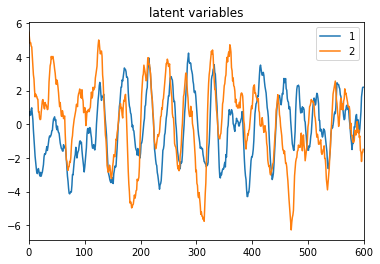

In [58]:
plt.figure()
for z in range(latent_dim):
    plt.plot(latent_test[:,z],label=str(z+1))
plt.xlim([0,600])
plt.title('latent variables')
plt.legend()
plt.show()

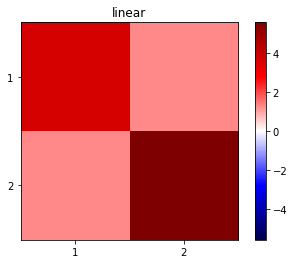

variance: [3.6737247 5.548989 ]  rank: [2 1]
determinant of corr matrix:  0.9159044705601767


In [75]:
cov = latent_test.T@latent_test/(Ntest-1)
# cov = latent_train.T@latent_train/(Ntrain-1)
# cov = np.cov(latent_test.T)
vmax = np.max(cov)
plt.figure()
plt.title('linear')
plt.imshow(cov,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,latent_dim+0.5,latent_dim+0.5,0.5]) # vmin=-1,vmax=1,
plt.xticks(np.arange(latent_dim)+1)
plt.yticks(np.arange(latent_dim)+1)
plt.colorbar()
plt.show()
sort_idx = np.argsort(np.diag(cov))
rank_var = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('variance:',np.diag(cov),' rank:',rank_var)

# covar_sum = np.sum(abs(cov-np.diag(np.diag(cov))),axis=0)
# sort_idx = np.argsort(covar_sum)
# rank_cov = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
# print('covariance sum',rank_cov)

det = np.linalg.det(np.corrcoef(latent_test.T))
print('determinant of corr matrix: ',det) 

In [82]:
pod_1 = md.POD(latent_test.T,method='classic')
m_1,lam_1 = pod_1.get_modes()
print(m_1,lam_1)

Calculating POD ...
User has selected classic POD
POD done.
[[ 0.45391235 -0.89104634]
 [ 0.89104634  0.45391235]] [6.18112656 2.97075016]


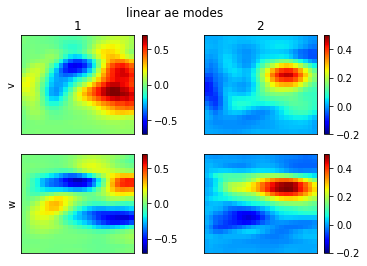

In [60]:
fig,ax = plt.subplots(2,2)
fig.suptitle('linear ae modes')
im00 = ax[0,0].imshow(linear_decoders[0].predict(np.reshape(1,(1,1)))[0,:,:,0],'jet',vmax=0.7,vmin=-0.7)
im10 = ax[1,0].imshow(linear_decoders[0].predict(np.reshape(1,(1,1)))[0,:,:,1],'jet',vmax=0.7,vmin=-0.7)
im01 = ax[0,1].imshow(linear_decoders[1].predict(np.reshape(1,(1,1)))[0,:,:,0],'jet',vmax=0.5,vmin=-0.2)
im11 = ax[1,1].imshow(linear_decoders[1].predict(np.reshape(1,(1,1)))[0,:,:,1],'jet',vmax=0.5,vmin=-0.2)
for x in ax.flatten():
    x.set_xticks([])
    x.set_yticks([])
ax[0,0].set_ylabel('v')
ax[1,0].set_ylabel('w')
ax[0,0].set_title('1')
ax[0,1].set_title('2')
plt.colorbar(im00,ax=ax[0,0])
plt.colorbar(im01,ax=ax[0,1])
plt.colorbar(im10,ax=ax[1,0])
plt.colorbar(im11,ax=ax[1,1])
plt.show()

In [61]:
print('mse loss ae mode 1:',tf.keras.losses.MeanSquaredError()(u_in_l,linear_modes[0,:,:,:,:]).numpy())
print('mse loss ae mode 2:',tf.keras.losses.MeanSquaredError()(u_in_l,linear_modes[1,:,:,:,:]).numpy())

mse loss ae mode 1: 1.5393095
mse loss ae mode 2: 1.5352898


## nonlinear before training

In [11]:
mdl_nonlinear = MD_Autoencoder(Nx,Nu,features_layers=features_layers,latent_dim=latent_dim,
        filter_window=filter_window,act_fct='tanh',batch_norm=batch_norm,
        drop_rate=drop_rate, lmb=lmb)

In [12]:
mdl_nonlinear.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 21, 24, 2)]  0           []                               
                                                                                                  
 encoder_1 (Encoder)            (None, 2)            260800      ['input_5[0][0]']                
                                                                                                  
 z_0 (Lambda)                   (None, 1)            0           ['encoder_1[0][0]']              
                                                                                                  
 z_1 (Lambda)                   (None, 1)            0           ['encoder_1[0][0]']              
                                                                                            

In [63]:
# load weights
mdl_nonlinear.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
mdl_nonlinear.evaluate(u_train[0,:,:,:,:],u_train[0,:,:,:,:],verbose=0)
mdl_nonlinear.load_weights('./__experiments/pre-training-linear-1.h5')
print('training loss after loading weights from linear pre-training:',mdl_nonlinear.evaluate(u_train[0,:,:,:,:],u_train[0,:,:,:,:],verbose=0))

training loss after loading weights from linear pre-training: 1.7780201435089111


In [64]:
# get decoders
latent_test_2 = mdl_nonlinear.encoder.predict(u_test[0,:,:,:,:])
nonlinear_decoders = []
for name in mdl_nonlinear.name_decoder:
    nonlinear_decoders.append(mdl_nonlinear.get_layer(name))

nonlinear_modes = []
for i in range(latent_dim):
    nonlinear_modes.append(nonlinear_decoders[i].predict(np.reshape(latent_test_2[:,i],(-1,1))))
nonlinear_modes = np.array(linear_modes)

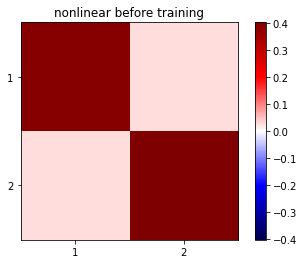

variance: [0.38928497 0.40207654]  rank: [2 1]
determinant of corr matrix:  0.948939699721142


In [76]:
cov_2 = latent_test_2.T@latent_test_2/(Ntest-1)
# cov = np.cov(latent_test.T)
vmax = np.max(cov_2)
plt.figure()
plt.title('nonlinear before training')
plt.imshow(cov_2,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,latent_dim+0.5,latent_dim+0.5,0.5]) # vmin=-1,vmax=1,
plt.xticks(np.arange(latent_dim)+1)
plt.yticks(np.arange(latent_dim)+1)
plt.colorbar()
plt.show()
sort_idx = np.argsort(np.diag(cov_2))
rank_var_2 = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('variance:',np.diag(cov_2),' rank:',rank_var_2)

# covar_sum = np.sum(abs(cov-np.diag(np.diag(cov))),axis=0)
# sort_idx = np.argsort(covar_sum)
# rank_cov = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
# print('covariance sum',rank_cov)

det_2 = np.linalg.det(np.corrcoef(latent_test_2.T))
print('determinant of corr matrix: ',det_2) 

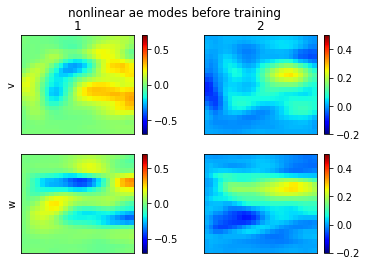

In [66]:
fig,ax = plt.subplots(2,2)
fig.suptitle('nonlinear ae modes before training')
m_1v = nonlinear_decoders[0].predict(np.reshape(1,(1,1)))[0,:,:,0]
m_1w = nonlinear_decoders[0].predict(np.reshape(1,(1,1)))[0,:,:,1]
m_2v = nonlinear_decoders[1].predict(np.reshape(1,(1,1)))[0,:,:,0]
m_2w = nonlinear_decoders[1].predict(np.reshape(1,(1,1)))[0,:,:,1]

im00 = ax[0,0].imshow(m_1v,'jet',vmax=0.7,vmin=-0.7)
im10 = ax[1,0].imshow(m_1w,'jet',vmax=0.7,vmin=-0.7)
im01 = ax[0,1].imshow(m_2v,'jet',vmax=0.5,vmin=-0.2)
im11 = ax[1,1].imshow(m_2w,'jet',vmax=0.5,vmin=-0.2)
for x in ax.flatten():
    x.set_xticks([])
    x.set_yticks([])
ax[0,0].set_ylabel('v')
ax[1,0].set_ylabel('w')
ax[0,0].set_title('1')
ax[0,1].set_title('2')
plt.colorbar(im00,ax=ax[0,0])
plt.colorbar(im01,ax=ax[0,1])
plt.colorbar(im10,ax=ax[1,0])
plt.colorbar(im11,ax=ax[1,1])

plt.show()

## nonlinear after training

In [17]:
hist_train_3 = []
hist_val_3 = []

In [18]:
pat = 100 # EarlyStopping
tempfn = './temp_training-nonlinear.h5'
model_cb=ModelCheckpoint(tempfn, monitor='val_loss',save_best_only=True,verbose=0,save_weights_only=True)
early_cb=EarlyStopping(monitor='val_loss', patience=pat,verbose=0)
cb = [model_cb, early_cb]

mdl_nonlinear.load_weights(tempfn)
# Training
hist0 = mdl_nonlinear.fit(u_train[0,:,:,:,:], u_train[0,:,:,:,:],
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(u_val[0,:,:,:,:], u_val[0,:,:,:,:]),
                callbacks=cb,verbose=2)  
hist_train_3.extend(hist0.history['loss'])
hist_val_3.extend(hist0.history['val_loss'])

Epoch 1/3000
15/15 - 3s - loss: 1.4075 - val_loss: 1.5395 - 3s/epoch - 198ms/step
Epoch 2/3000
15/15 - 0s - loss: 1.4113 - val_loss: 1.6595 - 424ms/epoch - 28ms/step
Epoch 3/3000
15/15 - 1s - loss: 1.4178 - val_loss: 1.5050 - 515ms/epoch - 34ms/step
Epoch 4/3000
15/15 - 0s - loss: 1.3974 - val_loss: 1.4988 - 493ms/epoch - 33ms/step
Epoch 5/3000
15/15 - 0s - loss: 1.3977 - val_loss: 1.5826 - 420ms/epoch - 28ms/step
Epoch 6/3000
15/15 - 0s - loss: 1.3969 - val_loss: 1.5700 - 460ms/epoch - 31ms/step
Epoch 7/3000
15/15 - 0s - loss: 1.4017 - val_loss: 1.5426 - 423ms/epoch - 28ms/step
Epoch 8/3000
15/15 - 0s - loss: 1.3928 - val_loss: 1.6589 - 425ms/epoch - 28ms/step
Epoch 9/3000
15/15 - 0s - loss: 1.3925 - val_loss: 1.5276 - 421ms/epoch - 28ms/step
Epoch 10/3000
15/15 - 0s - loss: 1.3931 - val_loss: 1.4998 - 420ms/epoch - 28ms/step
Epoch 11/3000
15/15 - 0s - loss: 1.3947 - val_loss: 1.5881 - 425ms/epoch - 28ms/step
Epoch 12/3000
15/15 - 0s - loss: 1.4072 - val_loss: 1.6238 - 426ms/epoch - 2

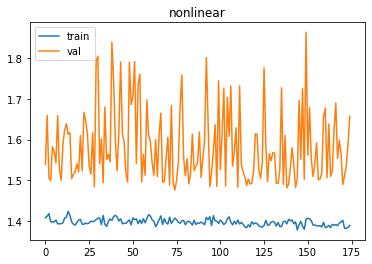

In [19]:
plt.figure()
plt.title('nonlinear')
plt.plot(hist_train_3,label='train')
plt.plot(hist_val_3,label='val')
plt.legend()
plt.show()

In [68]:
# training or testing
which = 'test'


mdl_nonlinear.load_weights('./__experiments/training-nonlinear-1.h5')
latent_test_3 = mdl_nonlinear.encoder.predict(u_test[0,:,:,:,:])
latent_train_3 = mdl_nonlinear.encoder.predict(u_train[0,:,:,:,:])
nonlinear_decoders_trained = []
for name in mdl_nonlinear.name_decoder:
    nonlinear_decoders_trained.append(mdl_nonlinear.get_layer(name))
nonlinear_modes_trained = []

if which == 'train':
    z = latent_train_3
    u_in = u_train[0,:,:,:,:]
elif which == 'test':
    z = latent_test_3
    u_in = u_test[0,:,:,:,:]

for i in range(latent_dim):
    nonlinear_modes_trained.append(nonlinear_decoders_trained[i].predict(np.reshape(z[:,i],(-1,1))))
nonlinear_modes_trained = np.array(nonlinear_modes_trained)
y_test_sum = np.sum(nonlinear_modes_trained,axis=0)
    
y_test = mdl_nonlinear.predict(u_in)

print('Are results calculated the two ways the same?',np.array_equal(y_test_sum,y_test))
loss_test_1 = mdl_nonlinear.evaluate(u_in,u_in,verbose=0)
loss_test_2 = tf.keras.losses.MeanSquaredError()(u_in,y_test)
print('total loss:',loss_test_1,'    mse loss:',loss_test_2.numpy())

Are results calculated the two ways the same? True
total loss: 1.4975613355636597     mse loss: 1.4744977


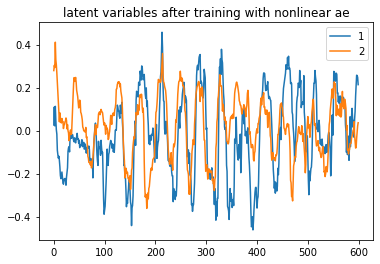

In [69]:
plt.figure()
plt.title('latent variables after training with nonlinear ae')
plt.plot(latent_test_3[:,0],label='1')
plt.plot(latent_test_3[:,1],label='2')
plt.legend()
plt.show()

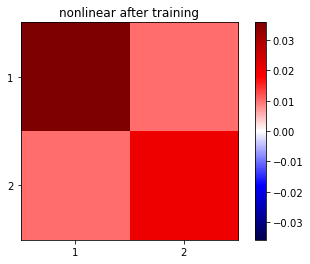

variance: [0.03589172 0.02016921]  rank: [1 2]
determinant of corr matrix:  0.8368321508477174


In [77]:
cov_3 = z.T@z/(z.shape[0]-1)
# cov = np.cov(latent_test.T)
vmax = np.max(cov_3)
plt.figure()
plt.title('nonlinear after training')
plt.imshow(cov_3,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,latent_dim+0.5,latent_dim+0.5,0.5]) # vmin=-1,vmax=1,
plt.xticks(np.arange(latent_dim)+1)
plt.yticks(np.arange(latent_dim)+1)
plt.colorbar()
plt.show()
sort_idx = np.argsort(np.diag(cov_3))
rank_var_3 = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('variance:',np.diag(cov_3),' rank:',rank_var_3)

# covar_sum = np.sum(abs(cov-np.diag(np.diag(cov))),axis=0)
# sort_idx = np.argsort(covar_sum)
# rank_cov = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
# print('covariance sum',rank_cov)

det_3 = np.linalg.det(np.corrcoef(z.T))
print('determinant of corr matrix: ',det_3) 

In [81]:
pod_1 = md.POD(z.T,method='classic')
m_1,lam_1 = pod_1.get_modes()
print(m_1,lam_1)

Calculating POD ...
User has selected classic POD
POD done.
[[-0.89021688  0.45553694]
 [-0.45553694 -0.89021688]] [0.04078607 0.0143987 ]


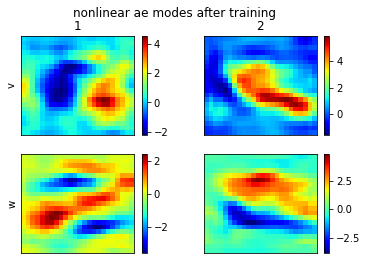

In [71]:
fig,ax = plt.subplots(2,2)
fig.suptitle('nonlinear ae modes after training')
im00 = ax[0,0].imshow(nonlinear_decoders[0].predict(np.reshape(1,(1,1)))[0,:,:,0],'jet')
im10 = ax[1,0].imshow(nonlinear_decoders[0].predict(np.reshape(1,(1,1)))[0,:,:,1],'jet')
im01 = ax[0,1].imshow(nonlinear_decoders[1].predict(np.reshape(1,(1,1)))[0,:,:,0],'jet')
im11 = ax[1,1].imshow(nonlinear_decoders[1].predict(np.reshape(1,(1,1)))[0,:,:,1],'jet')
for x in ax.flatten():
    x.set_xticks([])
    x.set_yticks([])
ax[0,0].set_ylabel('v')
ax[1,0].set_ylabel('w')
ax[0,0].set_title('1')
ax[0,1].set_title('2')
plt.colorbar(im00,ax=ax[0,0])
plt.colorbar(im01,ax=ax[0,1])
plt.colorbar(im10,ax=ax[1,0])
plt.colorbar(im11,ax=ax[1,1])

plt.show()

Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
spectrum (first 5):  [0.48586525 0.79107835 0.95331143 0.97703898 0.98847704]


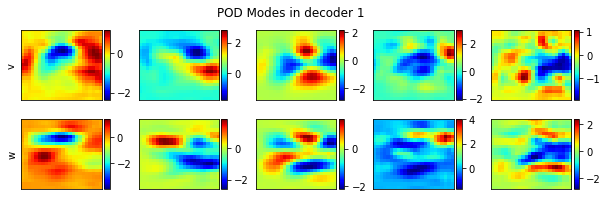

In [72]:
## decompose ae modes
which_decoder = 1-1
PlotWhichVelocity = 'v' 
save_img = False
vy = nonlinear_modes_trained[which_decoder,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = nonlinear_modes_trained[which_decoder,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
# POD
pod = md.POD(X)
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean


## plot POD
fig1 = plt.figure(figsize=(10, 3))
title = "POD Modes in decoder " + str(which_decoder+1)
plt.suptitle(title)

# v
grid0 = ImageGrid(fig1,211,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid0.axes_llc.set_xticks([])
grid0.axes_llc.set_yticks([])
grid0.axes_llc.set_ylabel('v')
iphi = 0
for ax, cax in zip(grid0, grid0.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[Ny:,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1
# w
grid1 = ImageGrid(fig1,212,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid1.axes_llc.set_xticks([])
grid1.axes_llc.set_yticks([])
grid1.axes_llc.set_ylabel('w')
iphi = 0
for ax, cax in zip(grid1, grid1.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[0:Ny,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1


## Spectrum
energy_1 = np.cumsum(lam/np.sum(lam))
print('spectrum (first 5): ', energy_1[:5])


plt.show()

Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
spectrum (first 5):  [0.80960028 0.92561724 0.96670352 0.98404998 0.99548234]


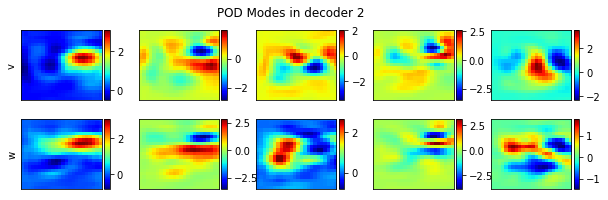

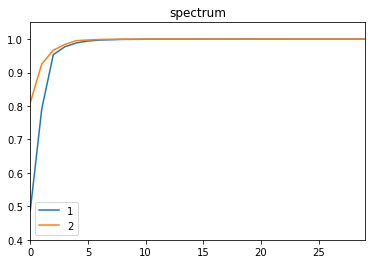

In [73]:
## decompose ae modes
which_decoder = 2-1
PlotWhichVelocity = 'v' 
save_img = False
vy = nonlinear_modes_trained[which_decoder,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = nonlinear_modes_trained[which_decoder,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
# POD
pod = md.POD(X)
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean


## plot POD
fig1 = plt.figure(figsize=(10, 3))
title = "POD Modes in decoder " + str(which_decoder+1)
plt.suptitle(title)

# v
grid0 = ImageGrid(fig1,211,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid0.axes_llc.set_xticks([])
grid0.axes_llc.set_yticks([])
grid0.axes_llc.set_ylabel('v')
iphi = 0
for ax, cax in zip(grid0, grid0.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[Ny:,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1
# w
grid1 = ImageGrid(fig1,212,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid1.axes_llc.set_xticks([])
grid1.axes_llc.set_yticks([])
grid1.axes_llc.set_ylabel('w')
iphi = 0
for ax, cax in zip(grid1, grid1.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[0:Ny,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1


## Spectrum
energy_2 = np.cumsum(lam/np.sum(lam))
print('spectrum (first 5): ', energy_2[:5])
plt.figure()
plt.plot(energy_1,label='1')
plt.plot(energy_2,label='2')
plt.title('spectrum')
plt.xlim([0,29])
plt.ylim([0.4,1.05])
plt.legend()

plt.show()

In [74]:
print('mse loss ae mode 1:',tf.keras.losses.MeanSquaredError()(u_in,nonlinear_modes_trained[0,:,:,:,:]).numpy())
print('mse loss ae mode 2:',tf.keras.losses.MeanSquaredError()(u_in,nonlinear_modes_trained[1,:,:,:,:]).numpy())

mse loss ae mode 1: 1.6779598
mse loss ae mode 2: 1.5610299
